# MegaFon Uplift Competition Dataset

The dataset is provided by MegaFon at the [MegaFon Uplift Competition](https://ods.ai/competitions/megafon-df21-comp) hosted in may 2021.

Here is a description of the fields:

- **id** (int): client id

- **treatment_group** (str): treatment/control group flag

- **X_1...X_50** (float): feature values

- **conversion** (binary): target

In [ ]:
import sys

# install uplift library scikit-uplift and other libraries 
!{sys.executable} -m pip install scikit-uplift dill lightgbm

In [1]:
from sklift.datasets import fetch_megafon
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklift.models import TwoModels
import lightgbm as lgb
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve

seed=31

## 📝 Load data

Dataset can be loaded from `sklift.datasets` module using `fetch_megafon` function.

In [2]:
# returns sklearn Bunch object
# with data, target, treatment keys
# data features (pd.DataFrame), target (pd.Series), treatment (pd.Series) values 

dataset = fetch_megafon()

In [3]:
print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (600000, 51)
Dataset target shape: (600000,)
Dataset treatment shape: (600000,)


## 📝 EDA

Let's have a look at the data features.

In [4]:
dataset.data.head().append(dataset.data.tail())

,id,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
0,0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,...,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365
1,1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,...,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234
2,2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,...,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636
3,3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,...,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299
4,4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,...,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858
599995,599995,33.031482,0.584463,-25.546737,-35.129322,6.603716,-90.384229,-44.399223,71.343628,26.439937,...,-183.820274,-167.259176,531.793092,-2.307605,-48.648490,0.763070,152.501250,-49.190995,149.292732,-15.031430
599996,599996,-24.469552,1.175070,35.936859,19.577711,81.505532,-164.141125,-8.221423,38.864814,-2.410108,...,103.792521,-87.706751,-230.298393,0.267790,-56.102467,-1.007702,-69.854583,187.924882,109.642972,25.022399
599997,599997,-57.592800,1.033326,-20.608920,87.116236,-27.894756,120.864975,40.592090,-34.134983,-26.821810,...,-97.993743,170.942462,299.211339,-0.930181,168.767350,-0.004762,-249.073528,-265.077308,-110.317964,-11.892925
599998,599998,-16.371510,-0.876885,-1.483559,32.407631,-57.148865,92.559125,-21.464004,-110.615734,58.100487,...,-17.409713,108.897052,223.509177,-0.832695,5.545312,0.659149,-156.605507,-41.757924,-89.330302,-22.886739
599999,599999,62.997565,-1.299755,-9.485073,4.682186,64.339233,-14.527508,-113.750106,195.634148,104.627105,...,-64.312678,48.114939,-231.497127,-0.022551,7.373350,0.213328,-235.624729,39.129831,-47.422068,-21.564626


In [5]:
dataset.data.describe()

,id,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,...,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,299999.500000,-3.758503,0.000405,0.356208,-1.004378,3.376919,-6.396371,-2.253712,-6.432606,-0.061507,...,6.882868,-6.632834,8.454493,0.001296,0.007967,-0.000966,-22.259600,-5.759041,6.241130,-1.176456
std,173205.225094,54.881882,0.999419,31.804123,45.291429,53.397644,140.873734,59.810396,74.840857,44.912292,...,163.776538,137.025868,262.840194,1.000368,71.553713,0.999902,500.900364,130.952113,141.211999,21.363662
min,0.000000,-271.659497,-4.372119,-148.870768,-244.446728,-302.574049,-683.126343,-322.731683,-506.202937,-218.466369,...,-810.842593,-633.575178,-1345.838757,-4.756720,-360.713742,-4.516004,-2506.960013,-687.526201,-702.184241,-98.094323
25%,149999.750000,-40.693313,-0.673108,-20.758308,-30.644608,-31.865404,-100.762161,-42.313674,-54.840796,-30.327330,...,-102.658380,-99.033996,-167.634846,-0.673780,-48.250836,-0.675549,-357.547278,-93.163915,-88.803657,-15.580688
50%,299999.500000,-3.954771,0.000915,0.372583,-0.585368,3.720738,-6.357443,-2.263690,-6.416419,-0.103742,...,7.190600,-6.784760,8.773280,0.001639,0.045537,-0.002251,-20.695017,-5.774627,6.286783,-1.199895
75%,449999.250000,33.174835,0.673056,21.495530,29.027860,38.988940,88.159514,37.709780,41.962767,30.144501,...,116.755600,85.621324,185.382370,0.675779,48.221733,0.673638,313.295748,81.636824,101.558007,13.230410
max,599999.000000,250.812280,5.062006,170.053291,235.095937,284.915947,656.482242,293.909622,550.525780,219.628423,...,867.086690,689.626208,1488.759454,4.727996,384.665348,5.086304,2534.503855,595.321844,630.727101,112.233293


In [9]:
dataset.data.dtypes.value_counts()

float64    50
int64       1
dtype: int64

In [6]:
print('Number NA:', dataset.data.isna().sum().sum())

Number NA: 0


There are 51 columns in the dataset: 50 feature values are float and id is integer. The dataset has no missing values.

###  Target and treatment 

Also take a look at target and treatment.

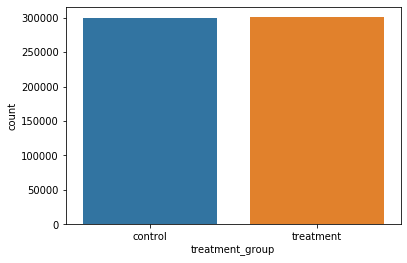

In [10]:
sns.countplot(x=dataset.treatment)

In [11]:
dataset.treatment.value_counts()

treatment    300368
control      299632
Name: treatment_group, dtype: int64

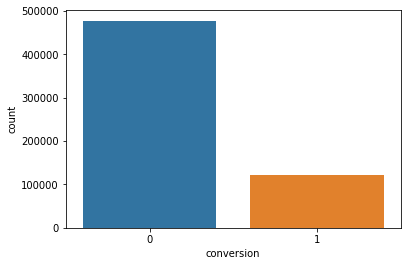

In [12]:
sns.countplot(x=dataset.target)

In [13]:
dataset.target.value_counts()

0    477486
1    122514
Name: conversion, dtype: int64

In [14]:
pd.crosstab(dataset.treatment, dataset.target, normalize='index')

conversion,0,1
treatment_group,,
control,0.820600,0.179400
treatment,0.771081,0.228919


As we can see, the target is not balanced.

### Simple baseline

Convert the **treatment** to binary values.

In [16]:
dataset.treatment.loc[dataset.treatment == 'treatment'] = 1
dataset.treatment.loc[dataset.treatment == 'control'] = 0

In [17]:
dataset.treatment.value_counts()

1    300368
0    299632
Name: treatment_group, dtype: int64

In a binary classification problem definition we stratify train set by splitting target `0/1` column. In uplift modeling we have two columns instead of one. 

In [18]:
stratify_cols = pd.concat([dataset.treatment, dataset.target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    dataset.data,
    dataset.treatment,
    dataset.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=31
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (420000, 51)
Validation shape: (180000, 51)


In [19]:
treatment_model = lgb.LGBMClassifier(random_state=31)
control_model = lgb.LGBMClassifier(random_state=31)
tm = TwoModels(estimator_trmnt = treatment_model, estimator_ctrl = control_model, method='vanilla')


In [20]:
tm = tm.fit(X_train, y_train, trmnt_train)

In [21]:
uplift_tm = tm.predict(X_val)

In [22]:
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_val, uplift_tm, trmnt_val) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: 0.2401


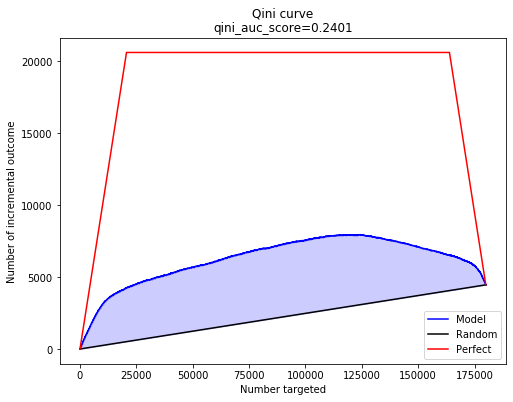

In [23]:
# with ideal Qini curve (red line)
# perfect=True

plot_qini_curve(y_val, uplift_tm, trmnt_val, perfect=True);